# Cell type classification

In [1]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects
from matplotlib.colors import ListedColormap
from anndata import AnnData, concat

# Customized packages
from starmap.utilities import *
from starmap.sequencing import *
from starmap.obj import STARMapDataset, load_data
# import starmap.analyze as anz
# import starmap.viz as viz
import starmap.sc_util as su

# test()

In [2]:
# Get functions 

import colorsys
from random import shuffle

def intervals(parts, start_point, end_point):
    duration = end_point - start_point
    part_duration = duration / parts
    return [((i * part_duration + (i + 1) * part_duration)/2) + start_point for i in range(parts)]

## IO

In [3]:
# Set path
base_path = 'Z:/Data/Analyzed/2022-01-03-Hu-AD/'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')

out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

## Input

In [4]:
# adata_1 = sc.read_h5ad('K:/2020-10-09-mAD-2766-genes-reads-assignment/output/2021-06-04-starmap-mAD-raw.h5ad')
# adata_2 = sc.read_h5ad(os.path.join(out_path, '2022-02-17-Hu-AD-stardist-filtered-4mad.h5ad'))

In [5]:
# # clean adata_1
# adata_1.obs = adata_1.obs.loc[:, adata_2.obs.columns]

# time_dict = {'13_months': '13months', '8_months': '8months'}
# adata_1.obs['time'] = adata_1.obs['time'].map(time_dict)

# sample_dict = {'AD_mouse9494': 'ADmouse_9494', 'AD_mouse9498': 'ADmouse_9498', 'AD_mouse9723': 'ADmouse_9723', 'AD_mouse9735': 'ADmouse_9735'}
# adata_1.obs['sample'] = adata_1.obs['sample'].map(sample_dict)

# adata_1 = adata_1[:, adata_2.var.index]

In [6]:
# adata = concat([adata_1, adata_2])
# adata.obs = adata.obs.reset_index(drop=True)
# adata.obs.index = adata.obs.index.astype(str)

In [32]:
adata = sc.read_h5ad(os.path.join(out_path, '2022-02-26-Hu-AD-stardist-filtered-3mad.h5ad'))
adata.var.index = adata.var.index.str.capitalize()
# adata.raw.var.index = adata.raw.var.index.str.capitalize()
adata

AnnData object with n_obs × n_vars = 72310 × 2766
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'tau', 'group', 'time', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'detected', 'highly_variable', 'n_cells'
    uns: 'dendrogram_sample'
    obsm: 'X_pca'
    layers: 'raw'

## Preprocessing

In [33]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.layers['norm'] = adata.X
adata.raw = adata

In [34]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X

# Batch correction
sc.pp.combat(adata)
adata.layers['corrected'] = adata.X

In [35]:
adata

AnnData object with n_obs × n_vars = 72310 × 2766
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'tau', 'group', 'time', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'detected', 'highly_variable', 'n_cells', 'mean', 'std'
    uns: 'dendrogram_sample', 'log1p'
    obsm: 'X_pca'
    layers: 'raw', 'norm', 'scaled', 'corrected'

## Top-level clustering

### clustering

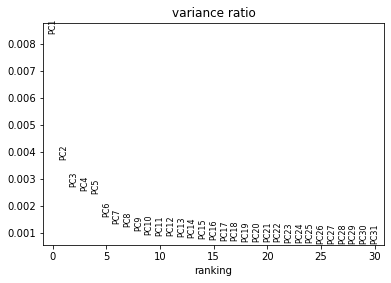

In [36]:
# Run PCA
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Plot explained variance 
sc.pl.pca_variance_ratio(adata, log=False)

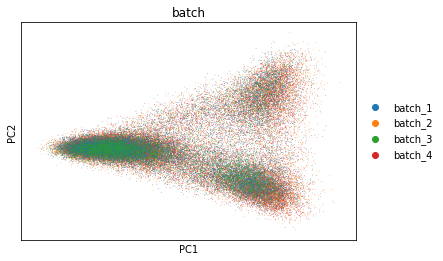

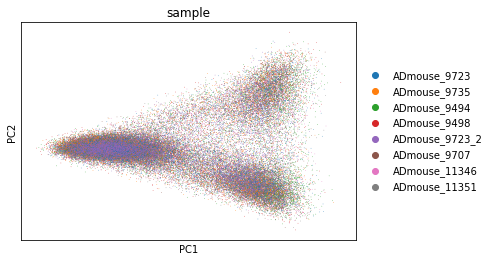

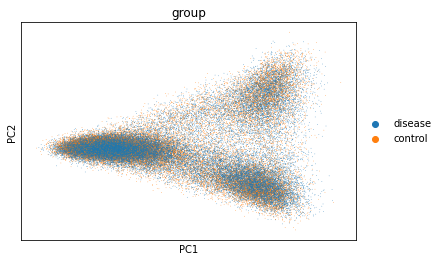

In [37]:
# Plot PCA
sc.pl.pca(adata, color='batch')
sc.pl.pca(adata, color='sample')
sc.pl.pca(adata, color='group')

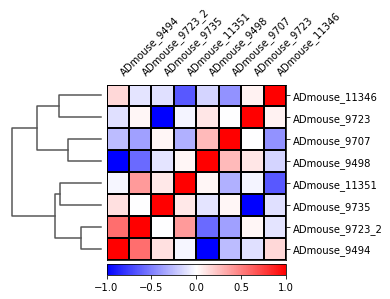

In [38]:
sc.tl.dendrogram(adata, groupby='sample', n_pcs=30, cor_method='spearman')
sc.pl.correlation_matrix(adata, 'sample', figsize=(5,3.5))

In [39]:
%%time
# Computing the neighborhood graph
n_neighbors = 50
n_pcs = 30 ## 30
min_dist = 0.05

sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata, min_dist=min_dist) ## 0.5

CPU times: total: 5min 6s
Wall time: 1min 51s


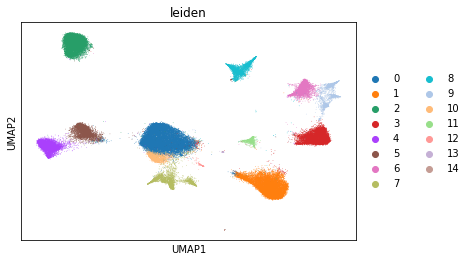

CPU times: total: 53.3 s
Wall time: 53.3 s


In [40]:
%%time
# Run leiden cluster
cluster_resolution = 1
sc.tl.leiden(adata, resolution = cluster_resolution)

# Plot UMAP with cluster labels 
sc.pl.umap(adata, color='leiden')
n_clusters = adata.obs['leiden'].unique().shape[0]

# Save log
with open(f'{fig_path}/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}
Min-distance: {min_dist}
Number of clusters: {n_clusters}""")

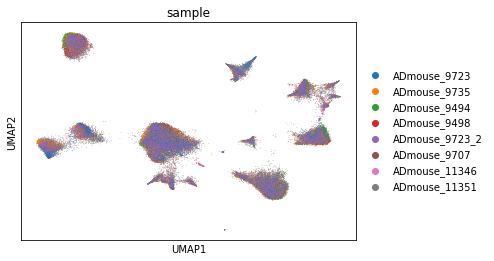

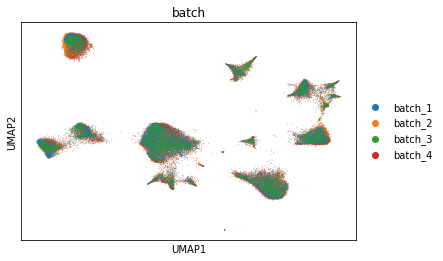

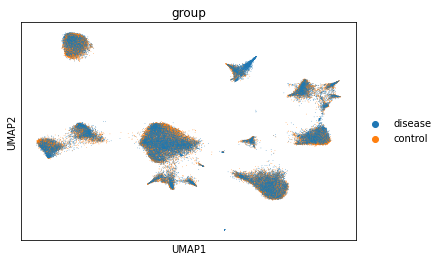

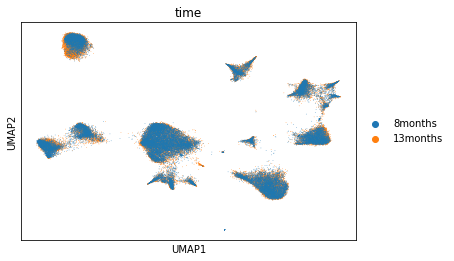

ADmouse_11346


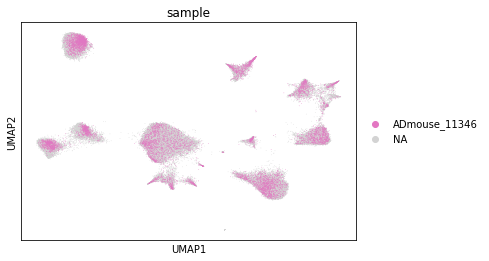

ADmouse_11351


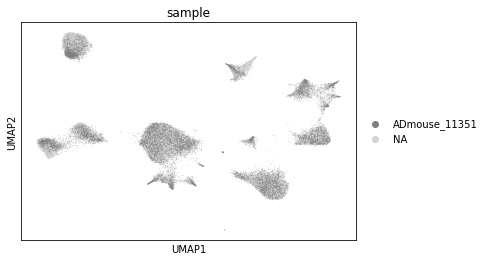

ADmouse_9494


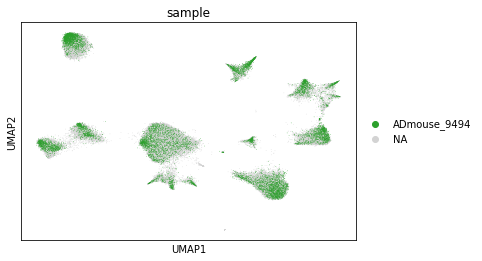

ADmouse_9498


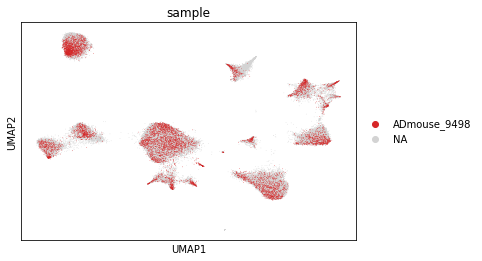

ADmouse_9707


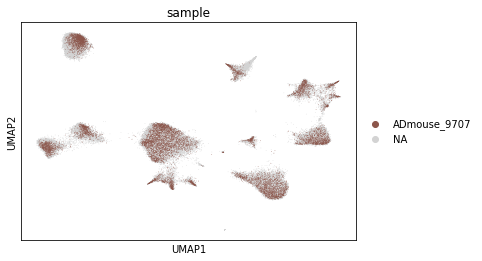

ADmouse_9723


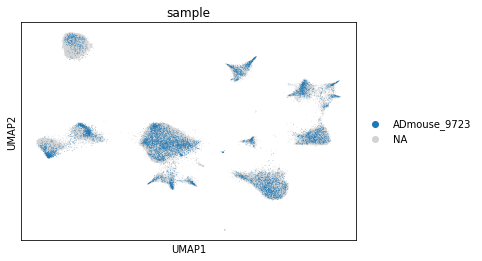

ADmouse_9723_2


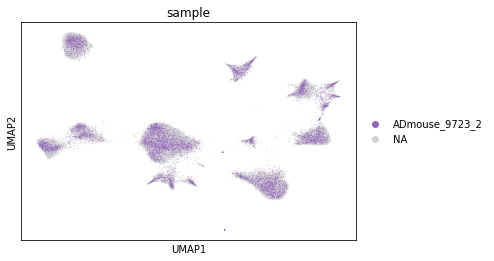

ADmouse_9735


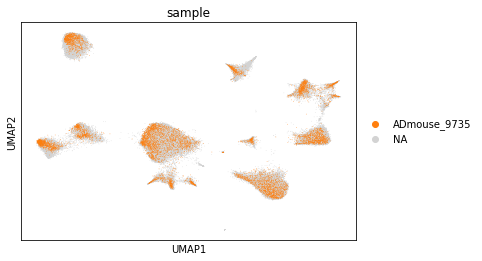

control


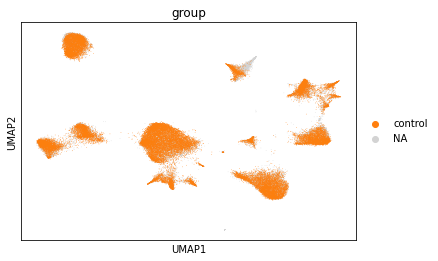

disease


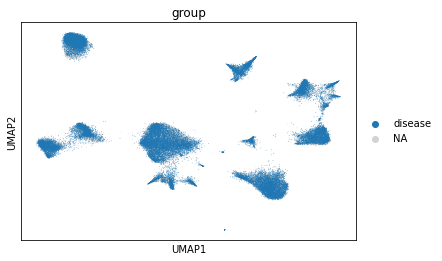

In [41]:
# Plot single meta UMAP
sc.pl.umap(adata, color='sample')
sc.pl.umap(adata, color='batch')
sc.pl.umap(adata, color='group')
sc.pl.umap(adata, color='time')

# Plot sample-wise UMAP
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    sc.pl.umap(adata, color='sample', groups=sample)

# Plot group-wise UMAP
for group in sorted(adata.obs['group'].unique()):
    print(group)
    sc.pl.umap(adata, color='group', groups=group)

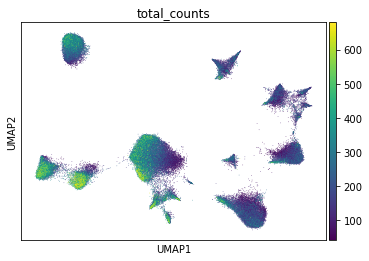

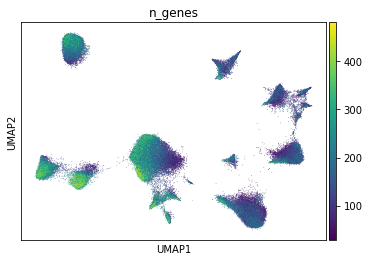

In [86]:
sc.pl.umap(adata, color='total_counts')
sc.pl.umap(adata, color='n_genes')

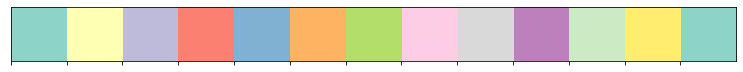

In [87]:
# Get colormap
cluster_pl = sns.color_palette("Set3", n_clusters)
cluster_cmap = ListedColormap(cluster_pl.as_hex())
sns.palplot(cluster_pl)

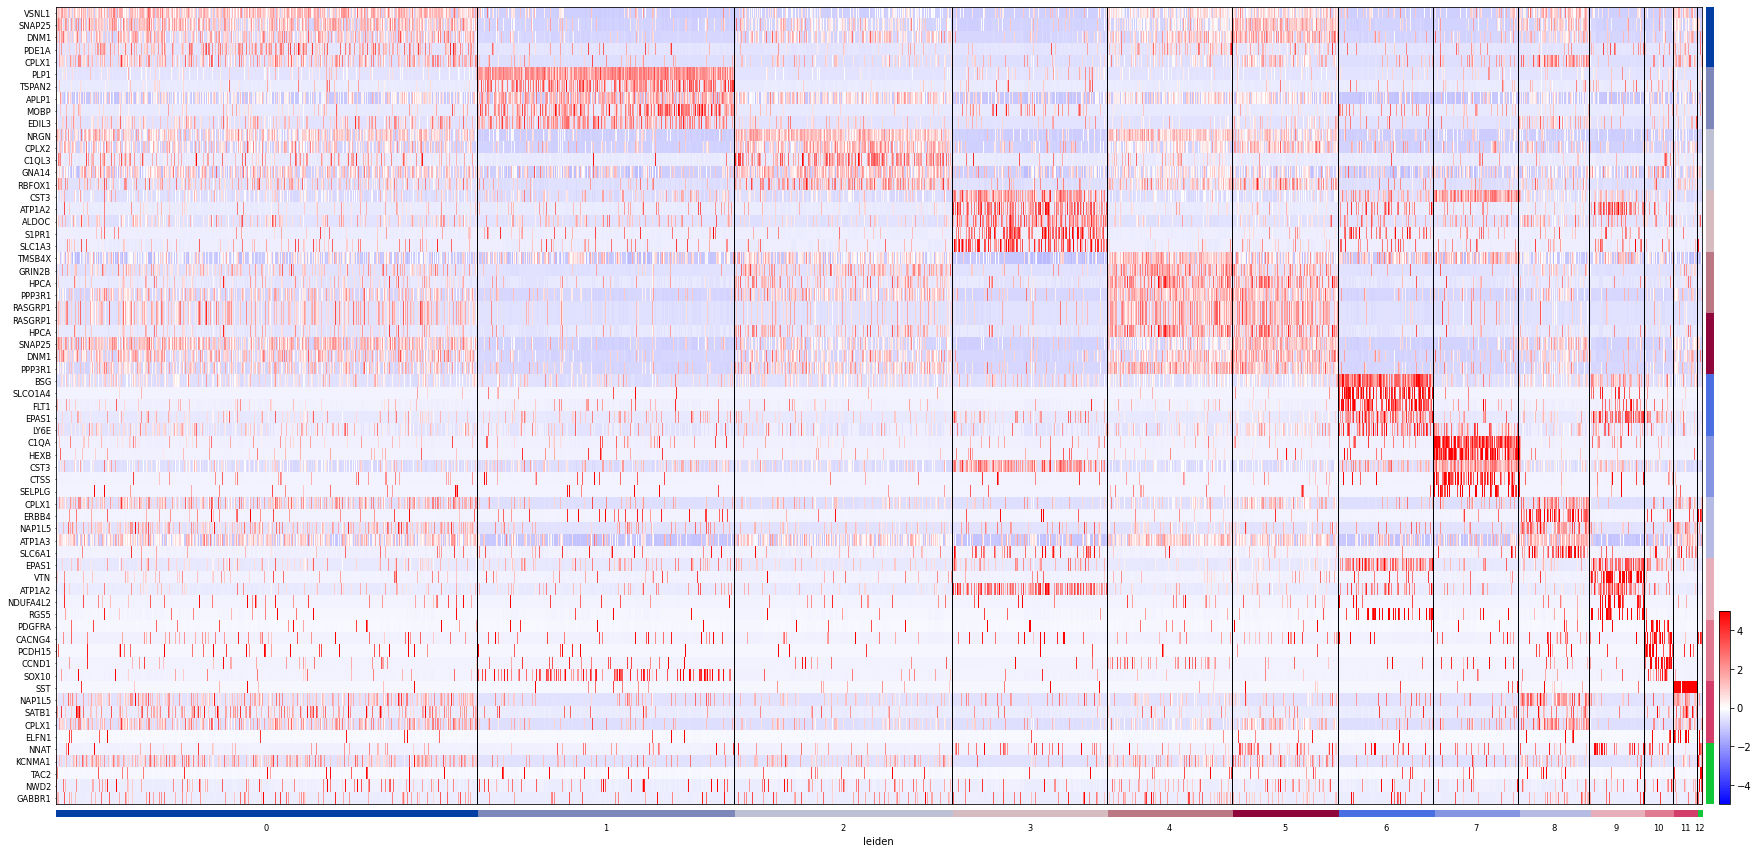

In [88]:
# Get markers for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=False)

### assign label

In [89]:
# Print markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

0 ['VSNL1', 'SNAP25', 'DNM1', 'PDE1A', 'NRGN']
1 ['PLP1', 'TSPAN2', 'APLP1', 'MOBP', 'EDIL3']
2 ['NRGN', 'CPLX2', 'C1QL3', 'GNA14', 'RBFOX1']
3 ['CST3', 'ATP1A2', 'ALDOC', 'S1PR1', 'SLC1A3']
4 ['TMSB4X', 'GRIN2B', 'HPCA', 'PPP3R1', 'RASGRP1']
5 ['RASGRP1', 'HPCA', 'SNAP25', 'DNM1', 'PPP3R1']
6 ['BSG', 'SLCO1A4', 'FLT1', 'EPAS1', 'LY6E']
7 ['C1QA', 'HEXB', 'CST3', 'CTSS', 'SELPLG']
8 ['CPLX1', 'ERBB4', 'NAP1L5', 'ATP1A3', 'SLC6A1']
9 ['EPAS1', 'VTN', 'ATP1A2', 'NDUFA4L2', 'RGS5']
10 ['PDGFRA', 'CACNG4', 'PCDH15', 'CCND1', 'SOX10']
11 ['SST', 'NAP1L5', 'SATB1', 'CPLX1', 'ATP1A3']
12 ['NNAT', 'KCNMA1', 'TAC2', 'NWD2', 'GABBR1']


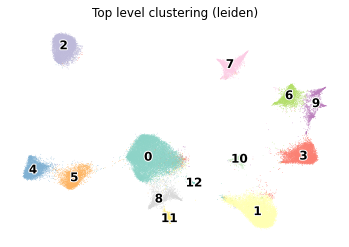

In [90]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=False)

In [92]:
# for current_sample in adata.obs['sample'].unique():
#     print(current_sample)
#     current_data = adata[adata.obs['sample'] == current_sample, :]
    
#     fig, ax = plt.subplots(figsize=(10, 10))
#     # plt.scatter(x=, y=, c=, s=, )
#     sns.scatterplot(x='x', y='y', hue='leiden', data=current_data.obs.loc[current_data.obs['leiden'] == '4', :], palette='tab20', s=10, legend=False)
#     ax.axis('off')
#     plt.show()

In [93]:
# Change cluster label to cell type label
transfer_dict = {}
top_level_list = ['CTX-Ex', 'Oligo', 'DG', 'Astro', 'CA1-Ex', 'CA3-Ex', 'Endo', 'Micro', 'Inh', 'SMC', 'OPC', 'Inh', 'LHb']

for i in sorted(adata.obs['leiden'].unique()):
    transfer_dict[i] = top_level_list[int(i)]

In [94]:
# Assign cell type to sdata
adata.obs['top_level'] = adata.obs['leiden'].values
adata.obs = adata.obs.replace({'top_level': transfer_dict})

# Remove NA 
adata = adata[adata.obs['top_level'] != 'NA', :]

# Sort category
top_level_order = ['CTX-Ex', 'Inh', 'CA1-Ex', 'CA3-Ex', 'DG', 'Astro', 'Endo', 'Micro', 'Oligo', 'OPC', 'SMC', 'LHb']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'].cat.reorder_categories(top_level_order, inplace=True)

Trying to set attribute `.obs` of view, copying.


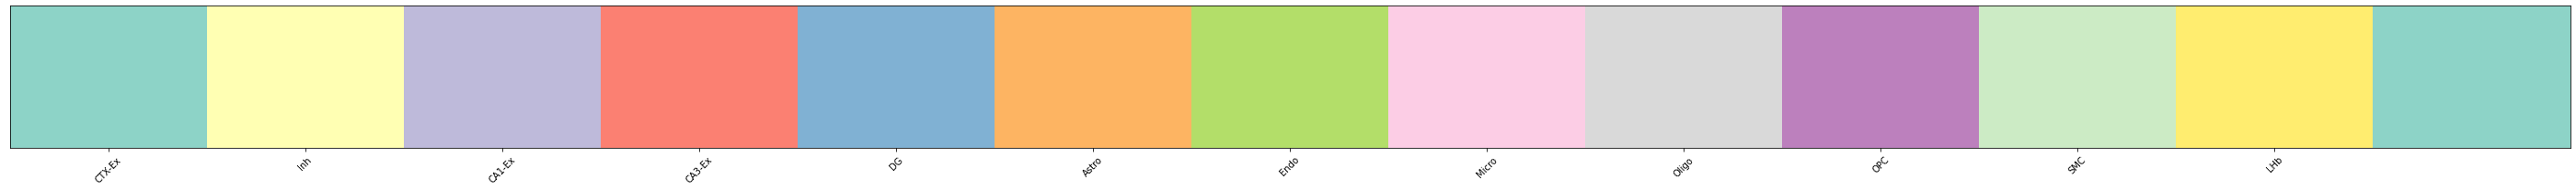

In [95]:
# Check color legend
sns.palplot(cluster_pl, size=3)
plt.xticks(range(len(top_level_order)), top_level_order, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_top.png')
plt.show()

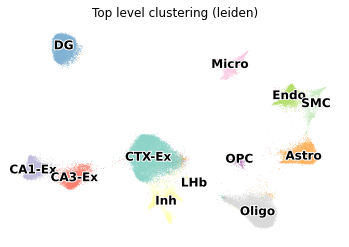

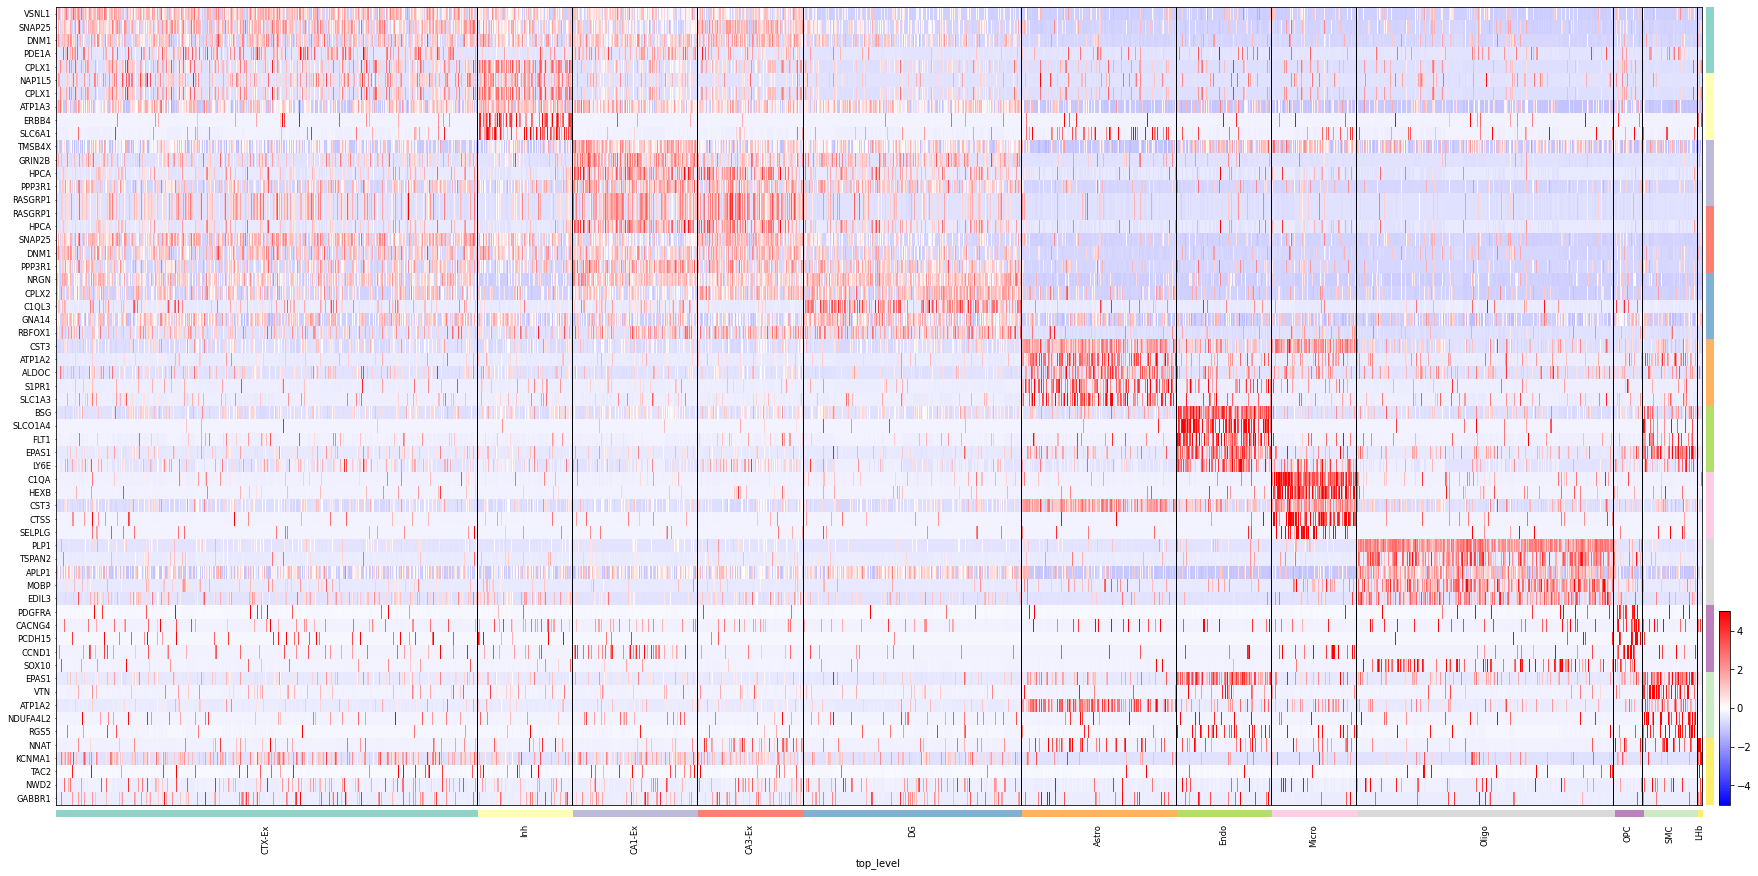

In [96]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=False)

sc.tl.rank_genes_groups(adata, 'top_level', method='wilcoxon')

# # Plot logFC heatmap
# sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
#                                 vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
#                                 dendrogram=False, figsize=(30, 15), save=False)

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=False)

# # Plot logFC dotplot
# sc.pl.rank_genes_groups_dotplot(adata, groupby='top_level', n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=1, 
#                                 vmax=5, vmin=-5, cmap='bwr', save=False)

### visual

In [116]:
# load reference data 
rdata = sc.read_h5ad('K:/2020-10-09-mAD-2766-genes-reads-assignment/output/2021-06-04-starmap-mAD-raw.h5ad')
rdata

AnnData object with n_obs × n_vars = 33106 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'region', 'cell_type_label'
    var: 'max_counts', 'detected'
    uns: 'AD_mouse9494_morph', 'AD_mouse9498_morph', 'AD_mouse9723_morph', 'AD_mouse9735_morph', 'cell_type_label_order', 'cell_type_order', 'label_hex_dict', 'label_rgb_dict', 'sub_hex_dict', 'sub_rgb_dict', 'top_hex_dict', 'top_level_order', 'top_rgb_dict'

In [117]:
# copy the colors
adata.uns['top_level_order'] = rdata.uns['top_level_order']
adata.uns['top_hex_dict'] = rdata.uns['top_hex_dict']
adata.uns['top_rgb_dict'] = rdata.uns['top_rgb_dict']

# adata.uns['top_level_order'] = rdata.uns['top_level_order'][:-1]
adata.uns['top_hex_dict'] = rdata.uns['top_hex_dict']
adata.uns['top_rgb_dict'] = rdata.uns['top_rgb_dict']

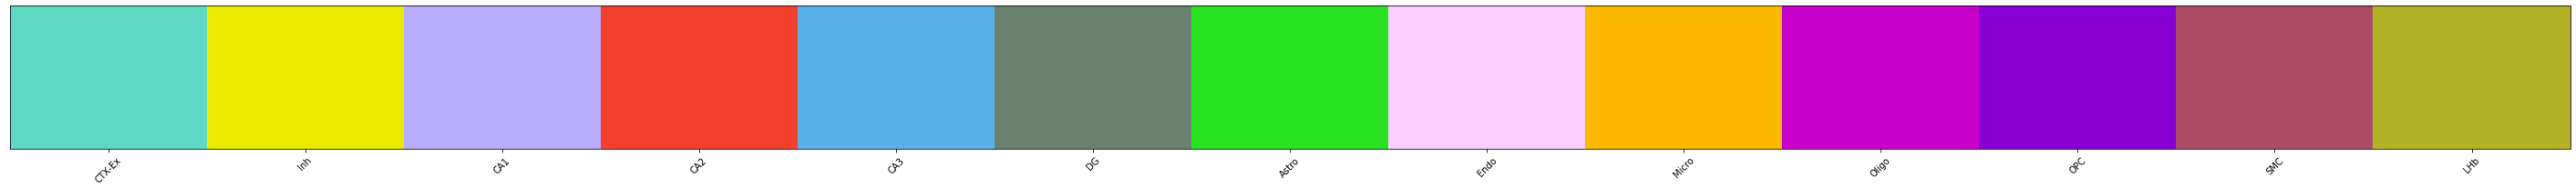

In [118]:
# Check color legend
top_cpl = []
for i in adata.uns['top_level_order']:
    top_cpl.append(adata.uns['top_rgb_dict'][i])

top_cpl = sns.color_palette(top_cpl)
top_cmap = ListedColormap(top_cpl.as_hex())
sns.palplot(top_cpl, size=3)
plt.xticks(range(len(adata.uns['top_level_order'])), adata.uns['top_level_order'], size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_top.png')
plt.show()

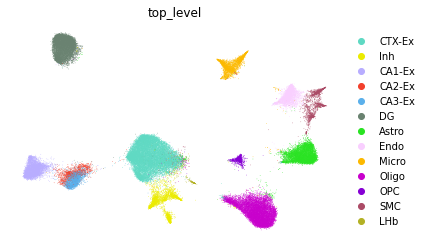

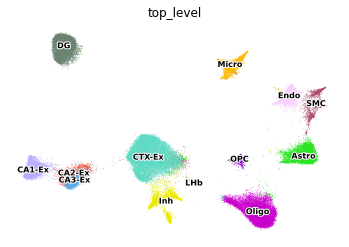

ADmouse_11346


Trying to set attribute `.uns` of view, copying.


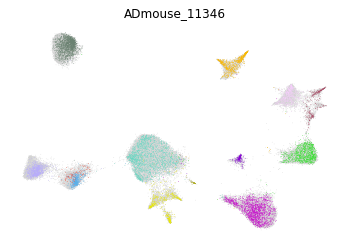

ADmouse_11351


Trying to set attribute `.uns` of view, copying.


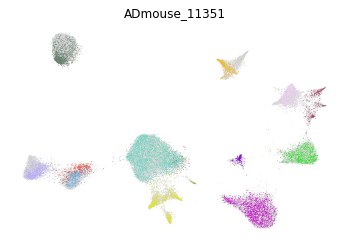

ADmouse_9494


Trying to set attribute `.uns` of view, copying.


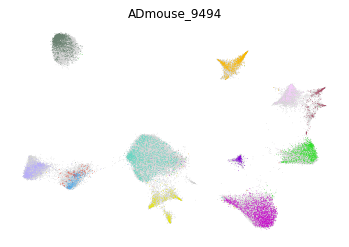

ADmouse_9498


Trying to set attribute `.uns` of view, copying.


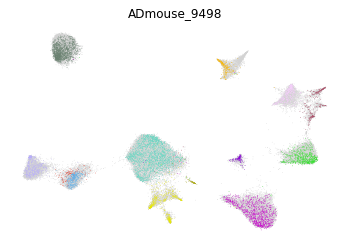

ADmouse_9707


Trying to set attribute `.uns` of view, copying.


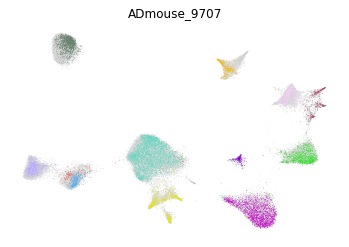

ADmouse_9723


Trying to set attribute `.uns` of view, copying.


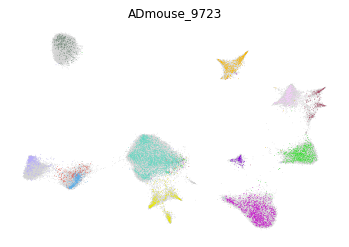

ADmouse_9723_2


Trying to set attribute `.uns` of view, copying.


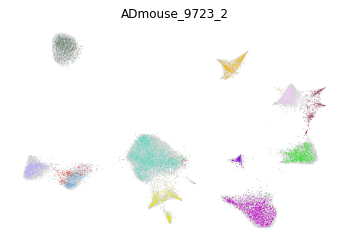

ADmouse_9735


Trying to set attribute `.uns` of view, copying.


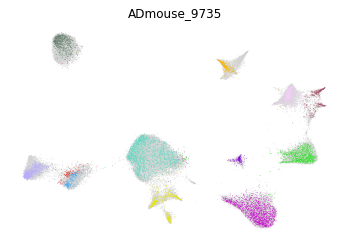

control


Trying to set attribute `.uns` of view, copying.


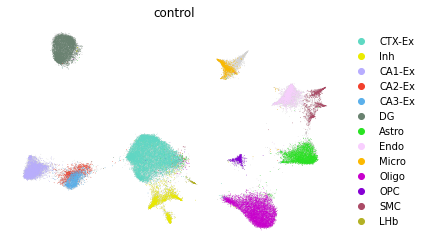

disease


Trying to set attribute `.uns` of view, copying.


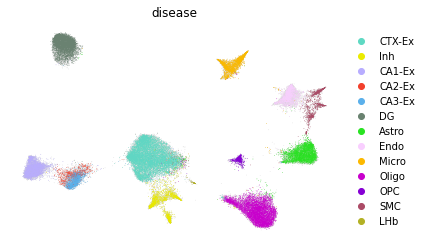

In [119]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', frameon=False, 
           palette=top_cpl, save=False)

# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=8, legend_fontoutline=2, frameon=False, 
           palette=top_cpl, save=False)

# Plot sample wise UMAP with top-level labels 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(adata, show=False, size=(120000 / adata.n_obs))
    sc.pl.umap(adata[adata.obs["sample"] == sample], color='top_level', frameon=False, ax=ax, size=(120000 / adata.n_obs), title=f"{sample}", legend_loc=None,
               palette=top_cpl, save=False)

# Plot group wise UMAP with top-level labels 
for group in sorted(adata.obs['group'].unique()):
    print(group)
    ax = sc.pl.umap(adata, show=False, size=(120000 / adata.n_obs))
    sc.pl.umap(adata[adata.obs["group"] == group], color='top_level', frameon=False, ax=ax, size=(120000 / adata.n_obs), title=f"{group}",
               palette=top_cpl, save=False)

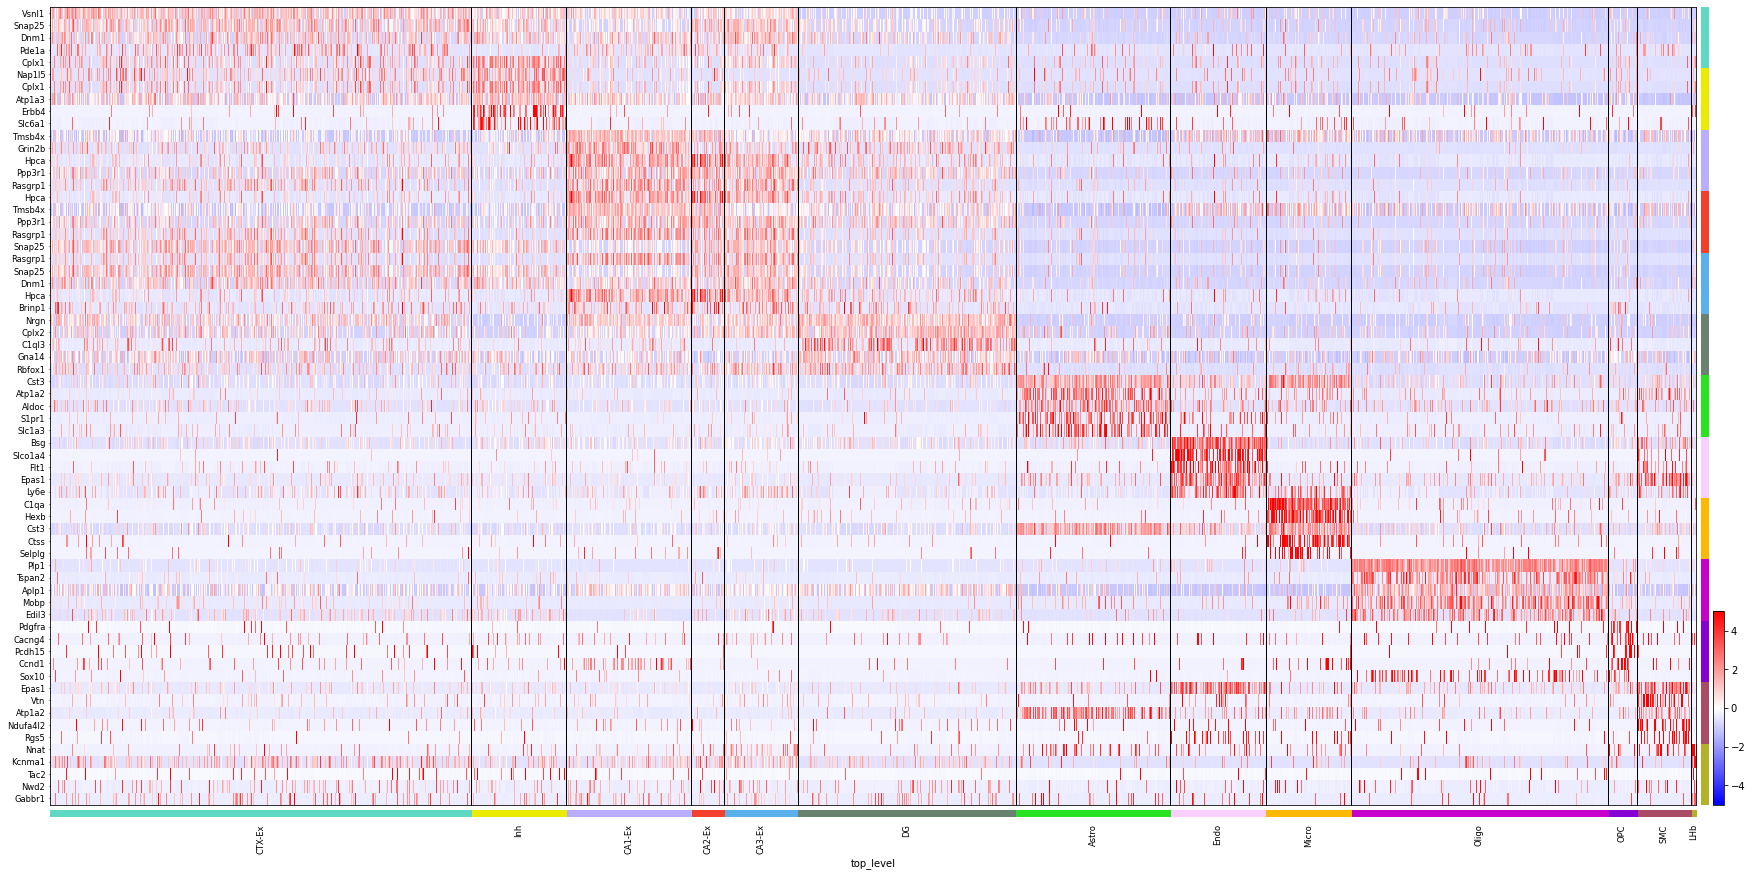

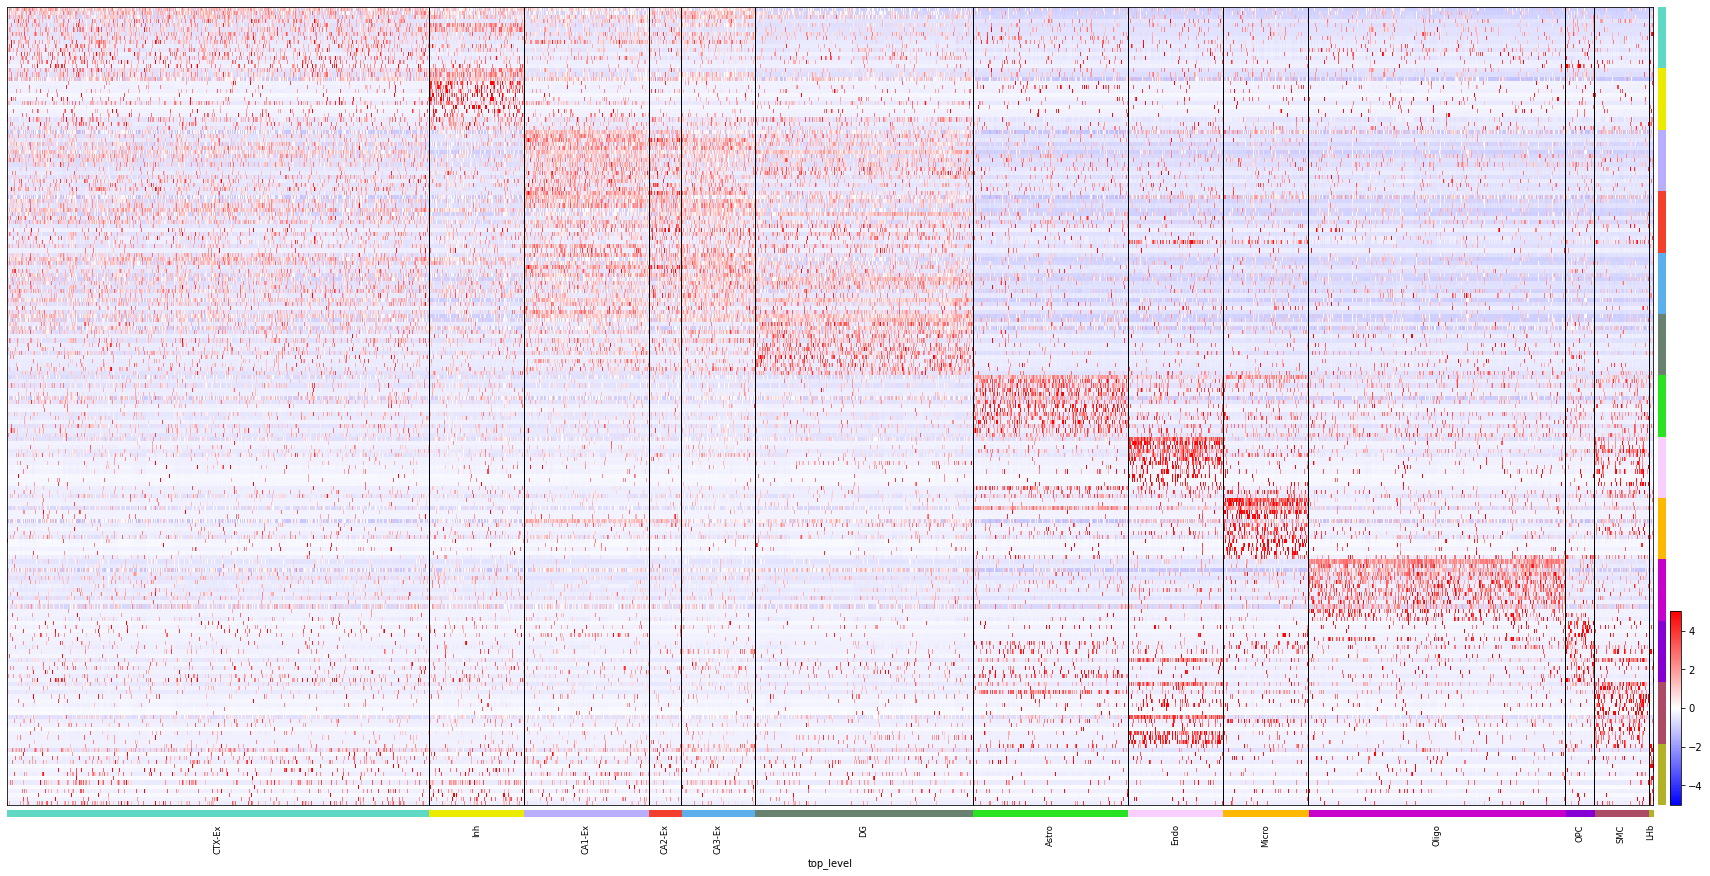

In [125]:
# Find gene markers for each cluster
sc.tl.rank_genes_groups(adata, 'top_level', method='wilcoxon')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=False)

# Plot z-score heatmap big
sc.pl.rank_genes_groups_heatmap(adata, n_genes=15, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=False,
                                dendrogram=False, figsize=(30, 15), save=False)

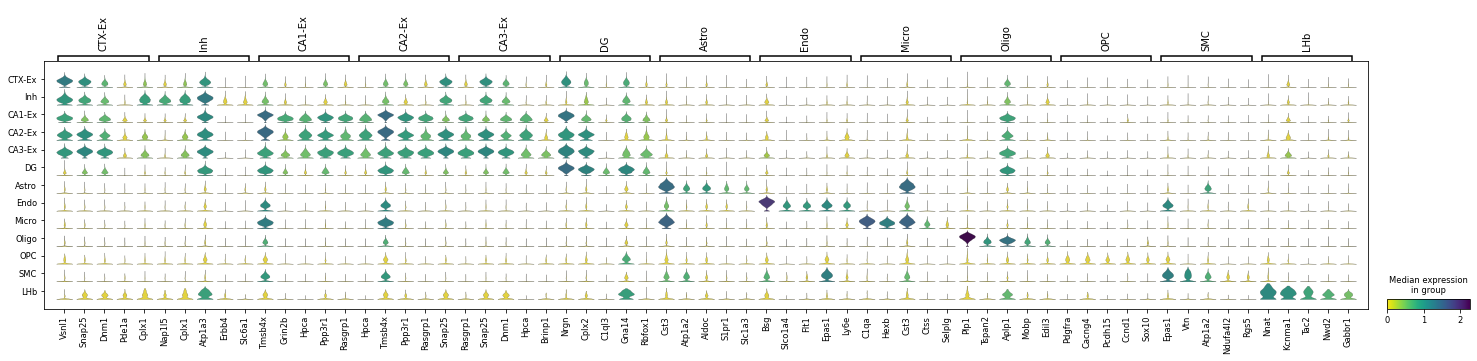

In [126]:
# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, 
                                       cmap='viridis_r', dendrogram=False, save=False)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


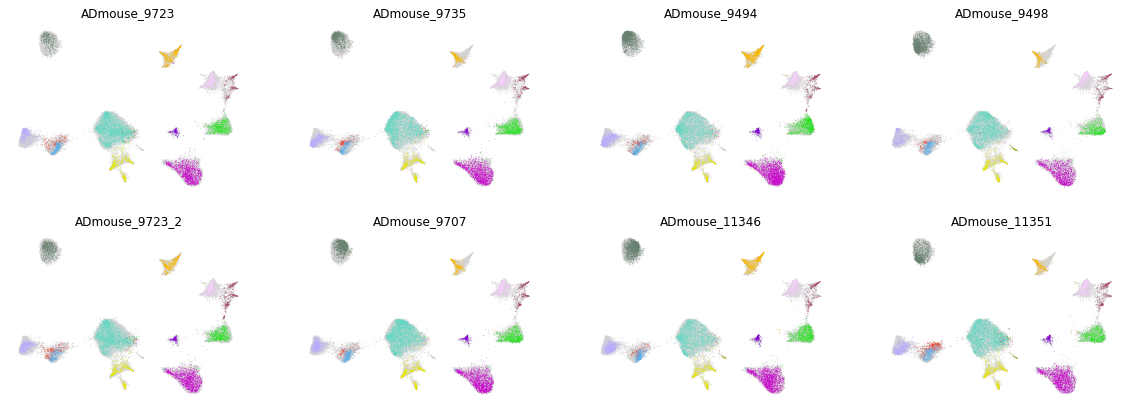

In [122]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))
axs = axs.flatten()
for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    ax = sc.pl.umap(adata, show=False, size=(120000 / adata.n_obs), ax=axs[i])
    sc.pl.umap(adata[adata.obs["sample"] == sample], color='top_level', frameon=False, ax=ax, size=(120000 / adata.n_obs), title=f"{sample}", legend_loc=None,
               palette=top_cpl, save=False, show=False)
    
plt.show()

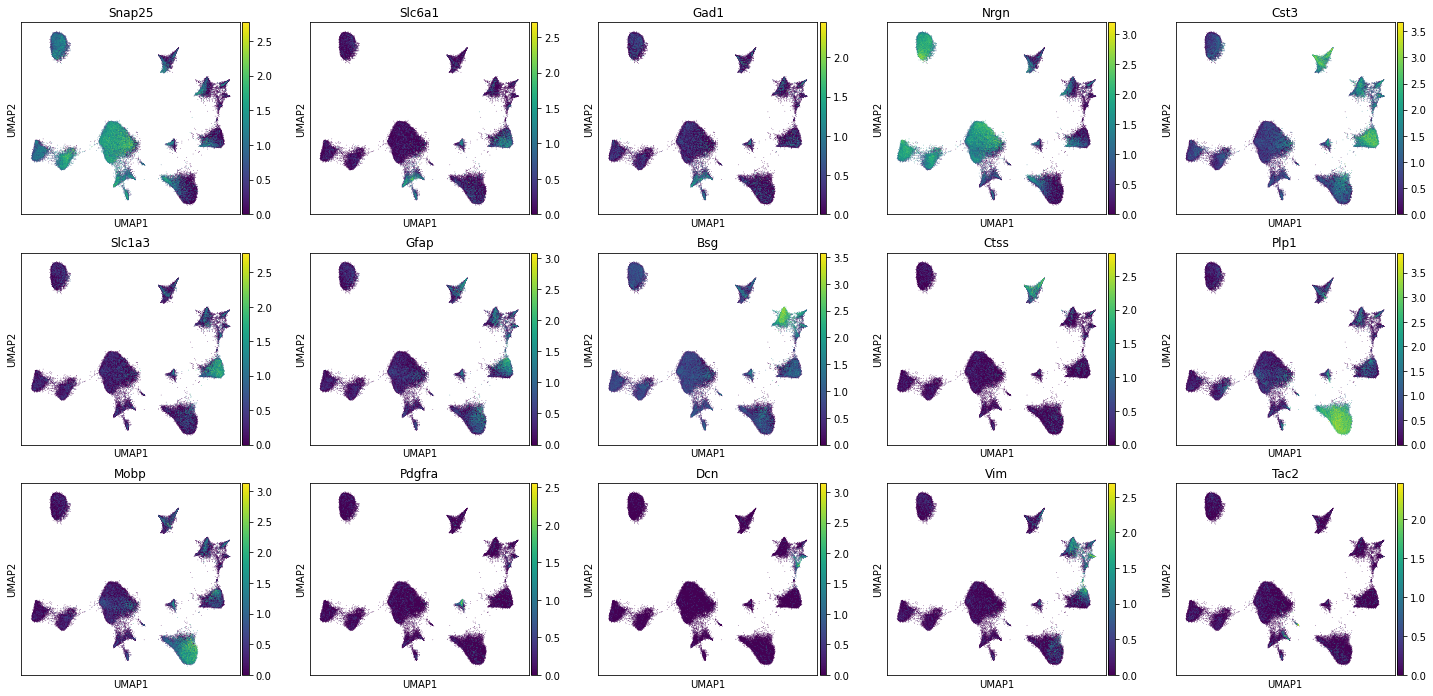

In [130]:
gene_list = ['Snap25', 'Slc6a1', 'Gad1', 'Nrgn', 'Cst3', 'Slc1a3', 'Gfap', 'Bsg', 'Ctss', 'Plp1', 'Mobp', 'Pdgfra', 'Dcn', 'Vim', 'Tac2']

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(25, 12))
axs = axs.flatten()
for i, gene in enumerate(gene_list):
    ax = sc.pl.umap(adata, color=gene, title=gene, ax=axs[i], show=False)
    
plt.show()

In [81]:
# for current_sample in adata.obs['sample'].unique():
#     print(current_sample)
#     current_data = adata[adata.obs['sample'] == current_sample, :]
    
#     fig, ax = plt.subplots(figsize=(56, 56))
#     # plt.scatter(x=, y=, c=, s=, )
#     sns.scatterplot(x='x', y='y', hue='top_level', data=current_data.obs, palette=top_cpl, s=150, legend=False)
#     ax.axis('off')
#     plt.show()

### sct

In [54]:
data_dirs = [d for d in os.listdir(base_path) if 'AD' in d]

for current_dir in data_dirs:
    print(current_dir)
    # Load segmentation
    current_seg_path = os.path.join(base_path, current_dir, 'segmentation/scaled')
    current_img = tifffile.imread(os.path.join(current_seg_path, 'labeled_cells.tif'))
    
    # Load plaque image
    current_plaque_path = os.path.join(current_seg_path, 'plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    # uniform manual threshold 
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Load tau image
    current_tau_path = os.path.join(current_seg_path, 'tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)

    # Store the images to adata object
    sample = current_dir.split('-')[1]
    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau

In [55]:
# Restore convex hull and top-level info
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'top_level'].cat.codes.values
    
    # add tau positive info
    # tau_threshold = 30
    # adata.uns[current_key]['tau_index'] = (adata.obs['tau'] > tau_threshold) & (current_index)
    

ADmouse_11346
Geting ConvexHull...
Used 10217 / 10217
ADmouse_11351
Geting ConvexHull...
Used 10803 / 10803
ADmouse_9494
Geting ConvexHull...
Used 10743 / 10743
ADmouse_9498
Geting ConvexHull...
Used 8239 / 8239
ADmouse_9707
Geting ConvexHull...
Used 10121 / 10121
ADmouse_9723
Geting ConvexHull...
Used 9189 / 9189
ADmouse_9723_2
Geting ConvexHull...
Used 8639 / 8639
ADmouse_9735
Geting ConvexHull...
Used 9189 / 9189


In [13]:
# Spatial cell type map
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(adata, sample, top_cmap, show_plaque=True, show_tau=True, linewidth=0.5,
                                        figscale=3, width=10, height=10, save=True, show=False)

AD_mouse9494
AD_mouse9498
AD_mouse9723
AD_mouse9735


In [57]:
# Spatial cell type map
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(adata, sample, top_cmap, show_plaque=True, show_tau=True, 
                                         save_as_real_size=True, linewidth=0.5,
                                        figscale=3, width=10, height=10, save=True, show=False)

ADmouse_11346
ADmouse_11351
ADmouse_9494
ADmouse_9498
ADmouse_9707
ADmouse_9723
ADmouse_9723_2
ADmouse_9735


## Sub-level clustering

In [41]:
# Create complete array
complete_cluster_pl = []
complete_cell_type_order = []

<hr>

### clustering

In [447]:
# Subset
sub_id = 'SMC'
curr_cells = adata.obs['top_level'] == sub_id
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 2397 × 2766
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'tau', 'group', 'time', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'top_level', 'cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'detected', 'highly_variable', 'n_cells', 'mean', 'std'
    uns: 'dendrogram_sample', 'log1p', 'pca', 'batch_colors', 'sample_colors', 'group_colors', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'time_colors', 'rank_genes_groups', 'top_level_colors', 'top_level_order', 'top_hex_dict', 'top_rgb_dict'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'norm', 'scaled', 'corrected'
    obsp: 'distances', 'connectivities'

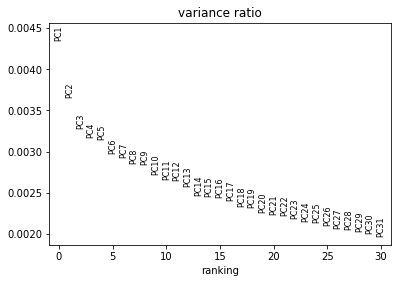

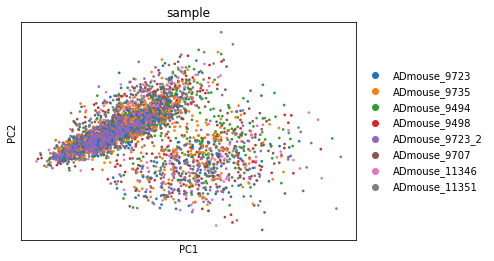

In [423]:
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack', use_highly_variable=True)

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Plot PCA
sc.pl.pca(sdata, color='sample')

In [450]:
%%time
# Computing the neighborhood graph
n_neighbors = 20
n_pcs = 15
min_dist = .1

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata, min_dist=min_dist)
sc.tl.diffmap(sdata, n_comps=n_pcs)

Wall time: 4.84 s


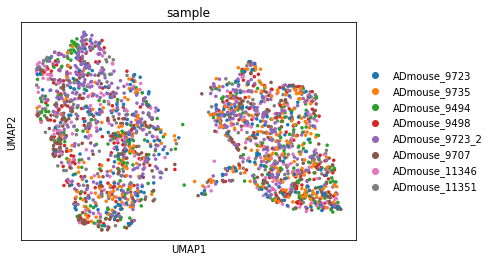

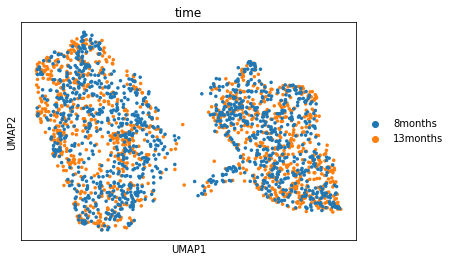

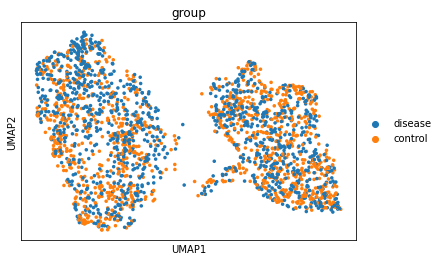

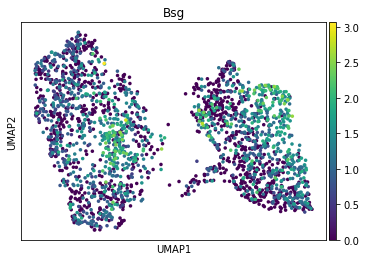

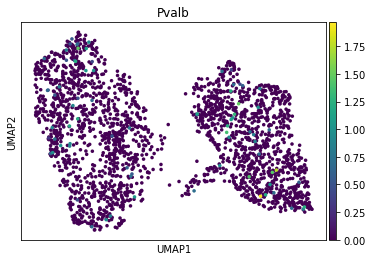

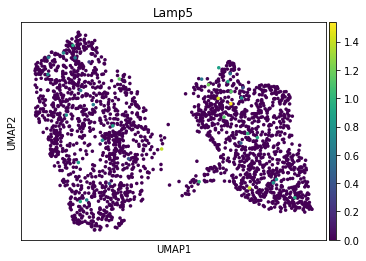

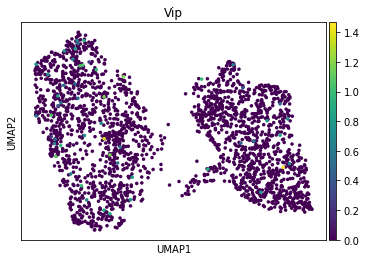

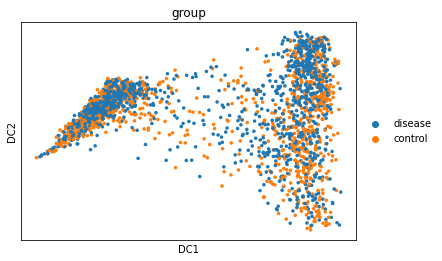

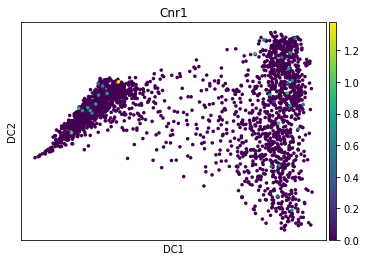

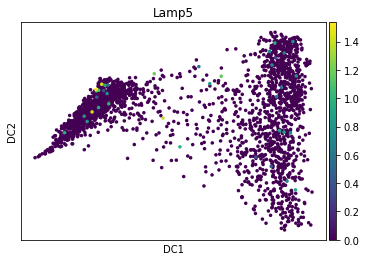

In [451]:
# Plot UMAP
sc.pl.umap(sdata, color='sample')
sc.pl.umap(sdata, color='time')
sc.pl.umap(sdata, color='group')
sc.pl.umap(sdata, color='Bsg')
sc.pl.umap(sdata, color='Pvalb')
sc.pl.umap(sdata, color='Lamp5')
sc.pl.umap(sdata, color='Vip')
sc.pl.diffmap(sdata, color='group')
sc.pl.diffmap(sdata, color='Cnr1')
sc.pl.diffmap(sdata, color='Lamp5')

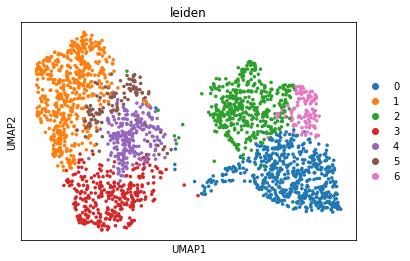

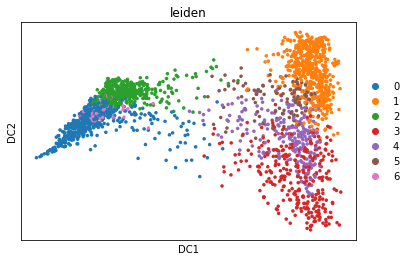

Wall time: 661 ms


In [455]:
%%time
# Run leiden cluster
cluster_resolution = .7
sc.tl.leiden(sdata, resolution = cluster_resolution)

# Plot UMAP with cluster labels 
sc.pl.umap(sdata, color='leiden')
sc.pl.diffmap(sdata, color='leiden')
n_clusters = sdata.obs['leiden'].unique().shape[0]

# Save log
with open(f'{fig_path}/log_{sub_id}.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}
Min-distance: {min_dist}
Number of clusters: {n_clusters}""")

In [456]:
# save embeddings
np.savetxt(f'{fig_path}/embedding_{sub_id}_umap.csv', sdata.obsm['X_umap'], delimiter=",")
np.savetxt(f'{fig_path}/embedding_{sub_id}_diffmap.csv', sdata.obsm['X_diffmap'], delimiter=",")

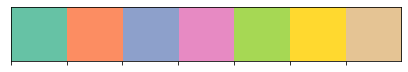

In [457]:
### Get colormap 
cluster_pl = sns.color_palette('Set2', n_clusters)
sns.palplot(cluster_pl)
cluster_cmap = ListedColormap(cluster_pl)

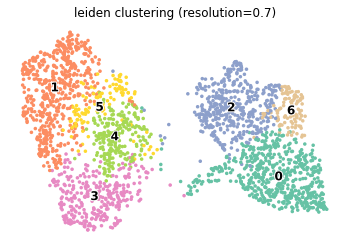

In [458]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=cluster_pl)

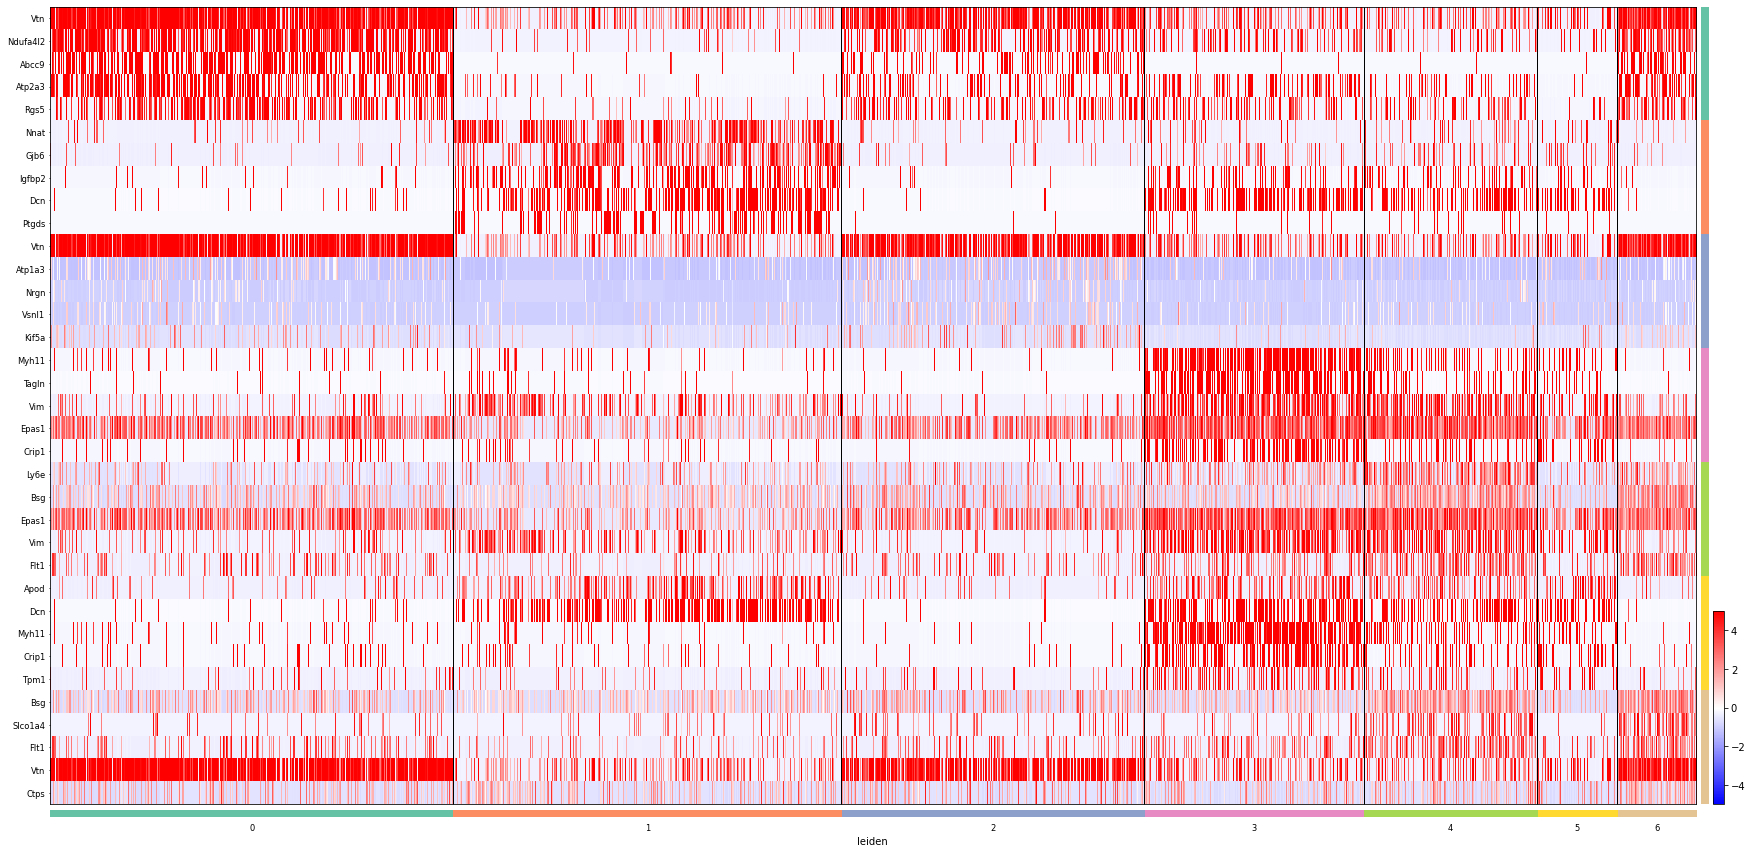

In [459]:
# Get markers for each cluster
sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, min_logfoldchange=.5, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=False)

In [460]:
# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(10)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

0 ['Vtn', 'Ndufa4l2', 'Abcc9', 'Atp2a3', 'Rgs5', 'Ano1', 'Dmd', 'Cald1', 'Atp1a2', 'Itga1']
1 ['Nnat', 'Gjb6', 'Igfbp2', 'Dcn', 'Ptgds', 'Igfbp5', 'Apoe', 'Cd63', 'Ctsb', 'Notch2']
2 ['Vtn', 'Atp1a3', 'Nrgn', 'Vsnl1', 'Kif5a', 'Cplx2', 'Aplp1', 'Snap25', 'Rab6b', 'Dlg4']
3 ['Myh11', 'Tagln', 'Vim', 'Epas1', 'Crip1', 'Dcn', 'Acta2', 'Tpm1', 'Apod', 'Itgb1']
4 ['Ly6e', 'Bsg', 'Epas1', 'Vim', 'Flt1', 'Pltp', 'Slco1a4', 'Cldn5', 'Dcn', 'Slc9a3r2']
5 ['Apod', 'Dcn', 'Myh11', 'Crip1', 'Tpm1', 'Ftl1', 'Tagln', 'Tpt1', 'Ckb', 'Npy1r']
6 ['Bsg', 'Slco1a4', 'Flt1', 'Vtn', 'Ctps', 'Abcc9', 'Cxcl12', 'Ly6e', 'Car4', 'Atp2a3']


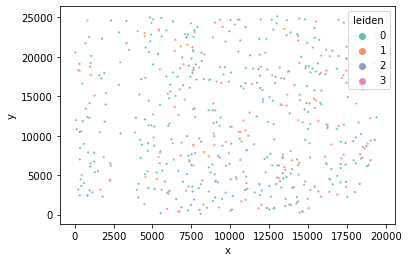

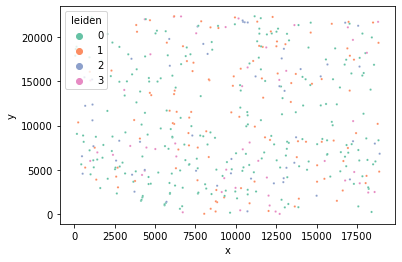

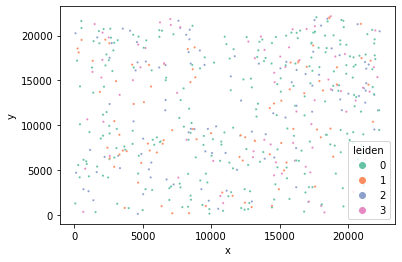

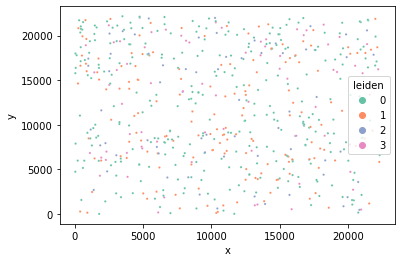

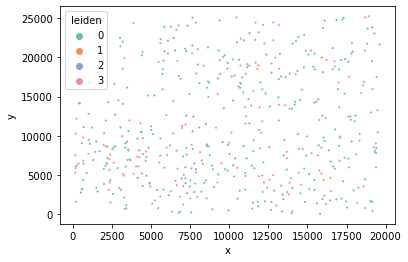

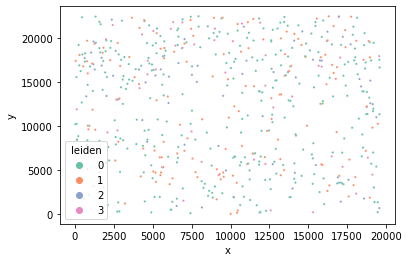

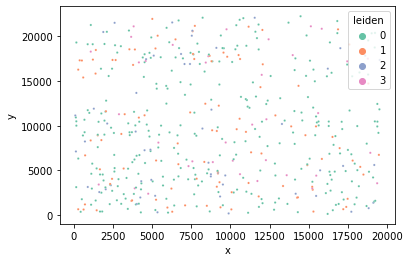

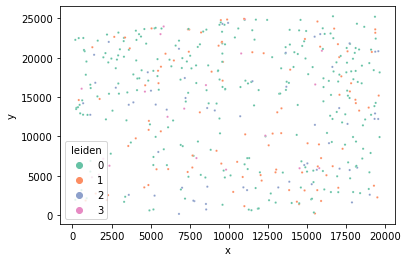

In [439]:
for current_sample in sdata.obs['sample'].unique():
    current_data = sdata[sdata.obs['sample'] == current_sample, :]
    
    fig, ax = plt.subplots()
    # plt.scatter(x=, y=, c=, s=, )
    sns.scatterplot(x='x', y='y', hue='leiden', data=current_data.obs, palette=cluster_pl, s=5)
    plt.show()

ADmouse_11351


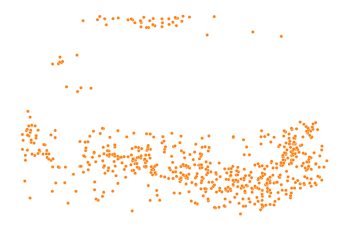

ADmouse_9498


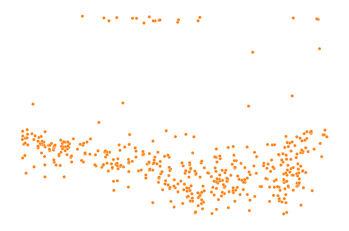

ADmouse_11346


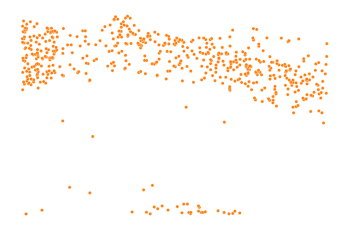

ADmouse_9494


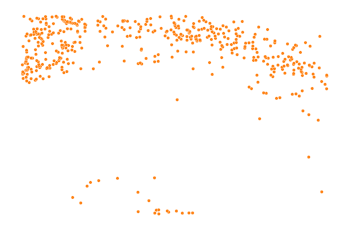

ADmouse_9707


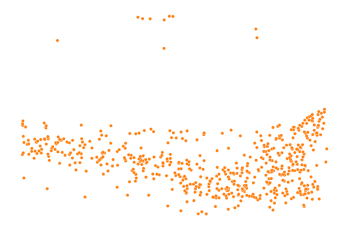

ADmouse_9735


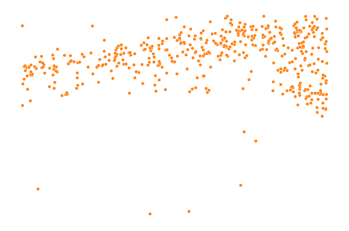

ADmouse_9723


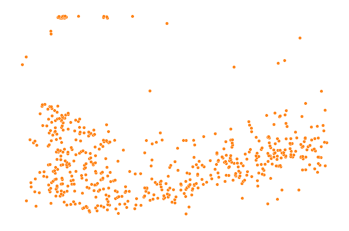

ADmouse_9723_2


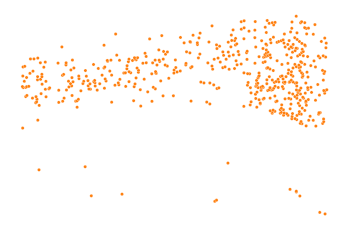

In [349]:
for current_sample in sdata.obs['sample'].unique():
    print(current_sample)
    current_data = sdata[sdata.obs['sample'] == current_sample, :]
    
    fig, ax = plt.subplots()
    # plt.scatter(x=, y=, c=, s=, )
    sns.scatterplot(x='x', y='y', hue='leiden', data=current_data.obs.loc[current_data.obs['leiden'] == '2', :], palette='tab20', s=10, legend=False)
    ax.axis('off')
    plt.show()

### assign label

In [465]:
rdata.obs.loc[rdata.obs['top_level'] == 'SMC', 'cell_type'].unique()

['VLMC_A', 'Peri_A', 'Peri_B', 'SMC', 'VLMC_B']
Categories (5, object): ['VLMC_A', 'Peri_A', 'Peri_B', 'SMC', 'VLMC_B']

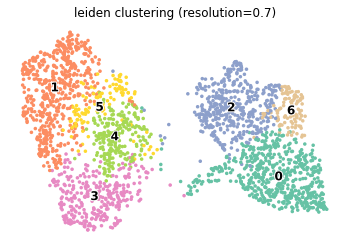

In [461]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=cluster_pl)

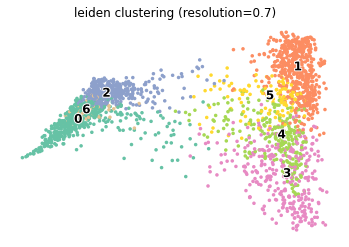

In [462]:
# Plot UMAP with cluster labels w/ new color
sc.pl.diffmap(sdata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=cluster_pl)

In [463]:
# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(10)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

0 ['Vtn', 'Ndufa4l2', 'Abcc9', 'Atp2a3', 'Rgs5', 'Ano1', 'Dmd', 'Cald1', 'Atp1a2', 'Itga1']
1 ['Nnat', 'Gjb6', 'Igfbp2', 'Dcn', 'Ptgds', 'Igfbp5', 'Apoe', 'Cd63', 'Ctsb', 'Notch2']
2 ['Vtn', 'Atp1a3', 'Nrgn', 'Vsnl1', 'Kif5a', 'Cplx2', 'Aplp1', 'Snap25', 'Rab6b', 'Dlg4']
3 ['Myh11', 'Tagln', 'Vim', 'Epas1', 'Crip1', 'Dcn', 'Acta2', 'Tpm1', 'Apod', 'Itgb1']
4 ['Ly6e', 'Bsg', 'Epas1', 'Vim', 'Flt1', 'Pltp', 'Slco1a4', 'Cldn5', 'Dcn', 'Slc9a3r2']
5 ['Apod', 'Dcn', 'Myh11', 'Crip1', 'Tpm1', 'Ftl1', 'Tagln', 'Tpt1', 'Ckb', 'Npy1r']
6 ['Bsg', 'Slco1a4', 'Flt1', 'Vtn', 'Ctps', 'Abcc9', 'Cxcl12', 'Ly6e', 'Car4', 'Atp2a3']


In [466]:
# Change cluster label to cell type label
transfer_dict = {}
# cell_type_list = ['CA3-Ex', 'CA2-Ex']
# cell_type_list = ['Micro1', 'Micro3', 'Micro2', 'Micro1']
# cell_type_list = ['Astro1', 'Astro2', 'Astro2', 'Astro3', 'Astro1', 'Astro2', 'Astro2', 'Astro1']
# cell_type_list = ['Oligo1', 'Oligo1', 'Oligo1', 'Oligo1', 'Oligo1', 'Oligo1', 'Oligo2', 'Oligo3']
# cell_type_list = ['CTX-Ex2', 'CTX-Ex1', 'CTX-Ex3', 'CTX-Ex4']
# cell_type_list = ['Pvalb', 'Cnr1', 'Sst', 'Sst', 'Pvalb', 'Pvalb_Nog', 'Lamp5', 'Vip', 'Pvalb', 'Lamp5', 'Pvalb']
# cell_type_list = ['Endo1', 'Endo2', 'Endo1', 'Endo3']
cell_type_list= ['S1', 'S3', 'S2', 'S4', 'S5', 'S5', 'S1']

for i in sorted(sdata.obs['leiden'].unique()):
    transfer_dict[i] = cell_type_list[int(i)]

In [467]:
# Assign cell type to sdata
sdata.obs['cell_type'] = sdata.obs['leiden'].values
sdata.obs = sdata.obs.replace({'cell_type': transfer_dict})

# Sort category
cell_type_list = sorted(cell_type_list)
sdata.obs['cell_type'] = sdata.obs['cell_type'].astype('category')
sdata.obs['cell_type'].cat.reorder_categories(sorted(list(set(cell_type_list))), inplace=True)

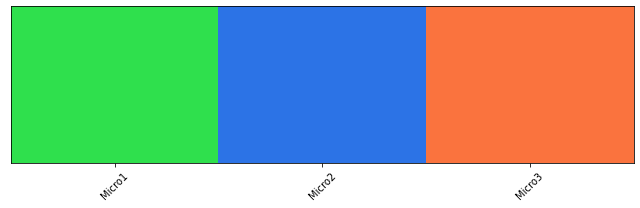

In [223]:
# new_color = True

# # Check color legend
# curr_cell_type = [] 
# for cell_type in sdata.uns['cell_type_order']:
#     if cell_type in sdata.obs['cell_type'].unique():
#         curr_cell_type.append(cell_type)

# sub_cpl = []
# for i in curr_cell_type:
#     if '/' in i:
#         curr_key = i.split('/')
#         sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
#     else:       
#         sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

# if new_color:
    # sub_cpl = ['#2fe04d', '#2c73e6', '#fa733e']
sub_cpl = ['#2fe04d', '#2c73e6', '#fa733e']
sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
# plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.xticks(range(len(sorted(list(set(cell_type_list))))), sorted(list(set(cell_type_list))), size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

In [224]:
# # Check color legend
# sns.palplot(cluster_pl, size=3)
# plt.xticks(range(len(cell_type_list)), cell_type_list, size=10, rotation=45)
# plt.tight_layout()
# # plt.savefig(f'./figures/color_legend_{sub_id}.png')
# plt.show()

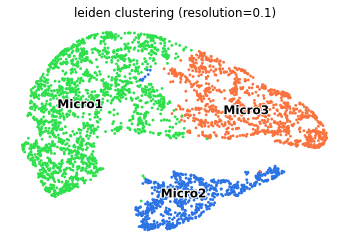

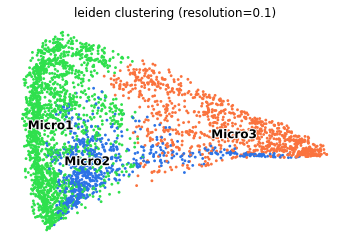

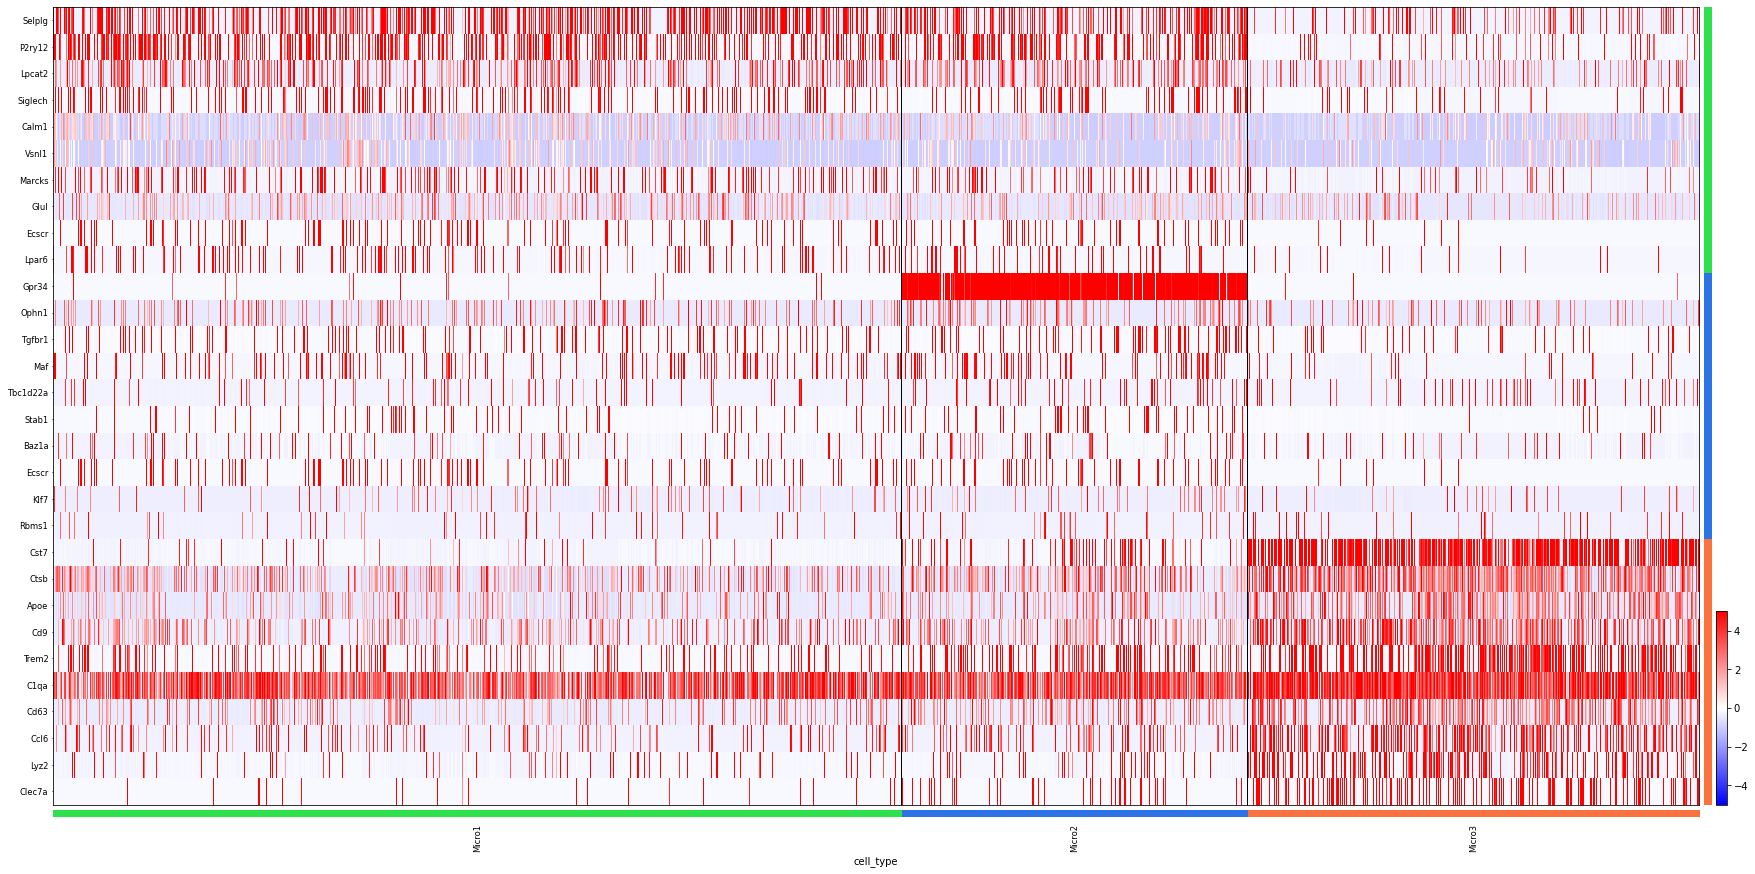

In [225]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='cell_type', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=sub_cpl, save=False)

sc.pl.diffmap(sdata, color='cell_type', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=sub_cpl, save=False)

sc.tl.rank_genes_groups(sdata, 'cell_type', method='wilcoxon')

# # Plot logFC heatmap
# sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=.5, use_raw=False, swap_axes=True, 
#                                 vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
#                                 dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=10, groupby='cell_type', min_logfoldchange=.5, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=False)

# # Plot logFC dotplot
# sc.pl.rank_genes_groups_dotplot(sdata, groupby='cell_type', n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=.5, 
#                                 vmax=5, vmin=-5, cmap='bwr', save='logFC')

# # Print markers 
# markers = []
# temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(5)
# for i in range(temp.shape[1]):
#     curr_col = temp.iloc[:, i].to_list()
#     markers = markers + curr_col
#     print(i, curr_col)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


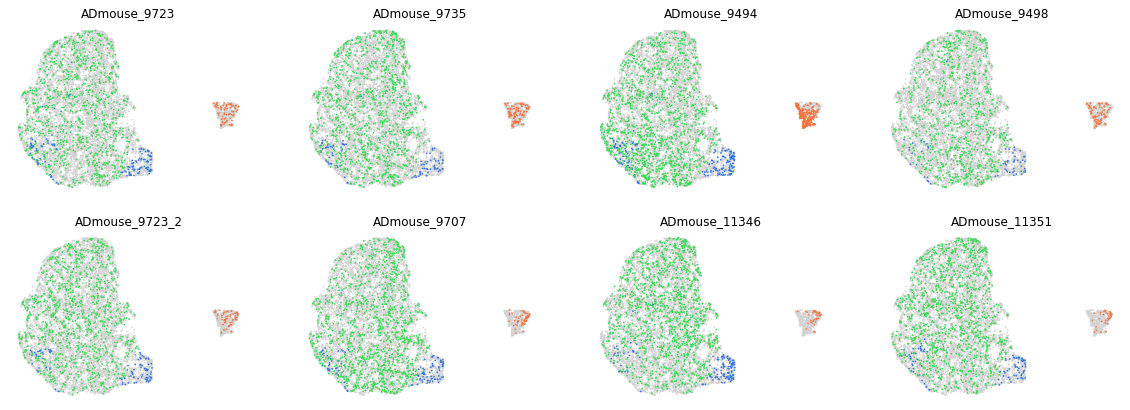

In [199]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))
axs = axs.flatten()
for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    current_data = sdata[sdata.obs["sample"] == sample, :]
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs), ax=axs[i])
    sc.pl.umap(current_data, color='cell_type', frameon=False, ax=ax, size=(120000 / sdata.n_obs), title=f"{sample}", legend_loc=None,
               palette=sub_cpl, save=False, show=False)
    
plt.show()

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


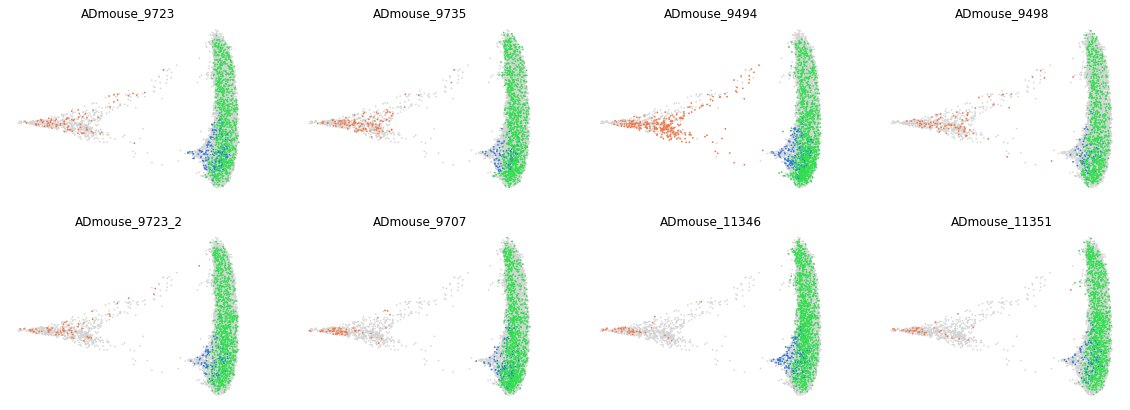

In [200]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))
axs = axs.flatten()
for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    current_data = sdata[sdata.obs["sample"] == sample, :]
    ax = sc.pl.diffmap(sdata, show=False, size=(120000 / sdata.n_obs), ax=axs[i])
    sc.pl.diffmap(current_data, color='cell_type', frameon=False, ax=ax, size=(120000 / sdata.n_obs), title=f"{sample}", legend_loc=None,
               palette=sub_cpl, save=False, show=False)
    
plt.show()

In [201]:
# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(10)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

0 ['Vsnl1', 'Atp1a3', 'Opalin', 'Nrgn', 'Gpm6a', 'Tspan7', 'Snap25', 'Il33', 'Cplx2', 'Rab6b']
1 ['Trf', 'Klk6', 'Mobp', 'Apod', 'Plp1', 'Mbp', 'Ndrg1', 'Car2', 'Tmsb4x', 'Ermn']
2 ['Cldn11', 'Dnm2', 'App', 'Tubb4a', 'Ctsb', 'Cd9', 'Ctps', 'Serpinb1b', 'Stmn4', 'Rimbp2']


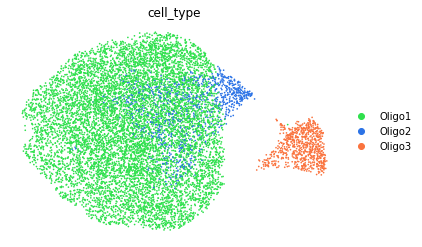

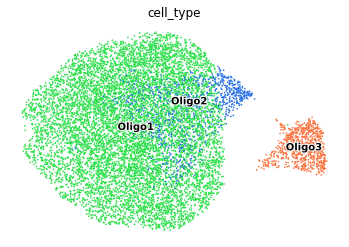

Trying to set attribute `.uns` of view, copying.


ADmouse_11346


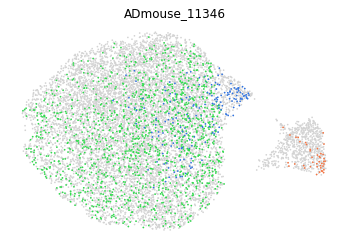

Trying to set attribute `.uns` of view, copying.


ADmouse_11351


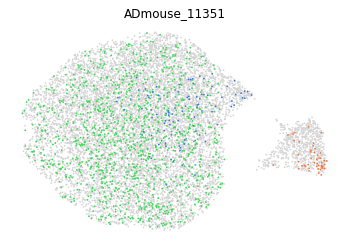

Trying to set attribute `.uns` of view, copying.


ADmouse_9494


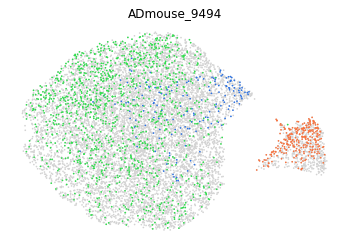

Trying to set attribute `.uns` of view, copying.


ADmouse_9498


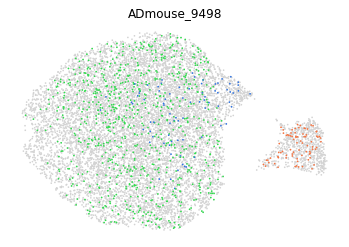

Trying to set attribute `.uns` of view, copying.


ADmouse_9707


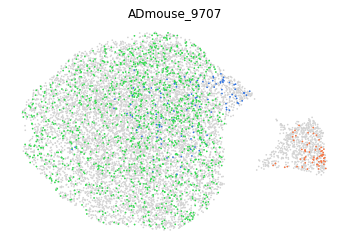

Trying to set attribute `.uns` of view, copying.


ADmouse_9723


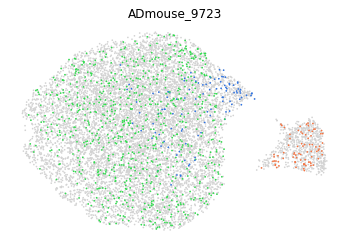

Trying to set attribute `.uns` of view, copying.


ADmouse_9723_2


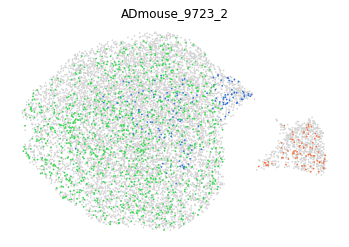

Trying to set attribute `.uns` of view, copying.


ADmouse_9735


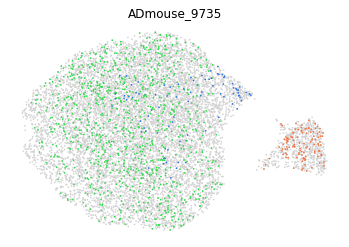

Trying to set attribute `.uns` of view, copying.


control


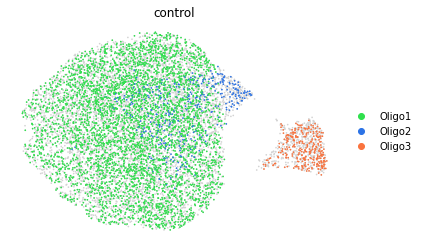

Trying to set attribute `.uns` of view, copying.


disease


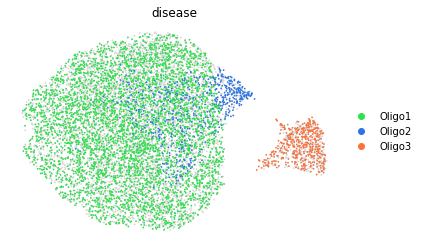

In [188]:
# dir_list = ['8months_disease', '8months_control', '13months_disease', '13months_control']
# sample_list = ['ADmouse_9723', 'ADmouse_9707', 'ADmouse_11346', 'ADmouse_11351']
# sample_dict = dict(zip(sample_list, dir_list))

# UMAP cell type label
sc.pl.umap(sdata, color='cell_type', frameon=False, 
           palette=sub_cpl, save=False)

# Save plots (cell_type_label)
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='cell_type', legend_loc='on data',
           legend_fontsize=10, legend_fontoutline=2, frameon=False, 
           palette=sub_cpl, save=False)

# Plot sample wise UMAP with sub-level labels 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["sample"] == sample], color='cell_type', frameon=False, ax=ax, size=(120000 / sdata.n_obs), title=f"{sample}", legend_loc=None,
               palette=sub_cpl, save=False)

# Plot group wise UMAP with sub-level labels 
for group in sorted(sdata.obs['group'].unique()):
    print(group)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["group"] == group], color='cell_type', frameon=False, ax=ax, size=(120000 / sdata.n_obs), title=f"{group}", 
               palette=sub_cpl, save=False)


In [ ]:
# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'cell_type'].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    su.plot_poly_cells_cluster_by_sample(sdata, sample, sub_cmap, show_plaque=True, show_tau=True,
                                         save_as_real_size=True, linewidth=0.5,
                                        figscale=3, width=10, height=10, save=False, show=True)

### CA2 (from CA3 subclustering)

In [112]:
adata.obs['top_level'] = adata.obs['top_level'].astype(object)
adata.obs.loc[curr_cells, 'top_level'] = sdata.obs['cell_type'].values

# Sort category
top_level_order = ['CTX-Ex', 'Inh', 'CA1-Ex', 'CA2-Ex', 'CA3-Ex', 'DG', 'Astro', 'Endo', 'Micro', 'Oligo', 'OPC', 'SMC', 'LHb']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'].cat.reorder_categories(top_level_order, inplace=True)

In [132]:
# save h5ad
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(f"{out_path}/{date}-Hu-AD-stardist-top_level_bk.h5ad")

### add to adata

In [468]:
# Map to original obj
if 'cell_type' not in adata.obs.columns:
    adata.obs['cell_type'] = adata.obs['top_level'].astype(object)
    
adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
adata.obs.loc[sdata.obs.index, 'cell_type'] = sdata.obs['cell_type'].values
adata.obs['cell_type'].unique()

array(['S5', 'S3', 'Astro2', 'Astro3', 'Endo2', 'Micro2', 'Vip', 'Pvalb',
       'Astro1', 'CTX-Ex1', 'CTX-Ex3', 'Oligo1', 'OPC', 'Micro1', 'Endo1',
       'Lamp5', 'S4', 'Endo3', 'S1', 'CTX-Ex2', 'Cnr1', 'Sst', 'S2',
       'CTX-Ex4', 'Pvalb_Nog', 'CA1-Ex', 'DG', 'CA2-Ex', 'CA3-Ex',
       'Oligo2', 'Oligo3', 'LHb', 'Micro3'], dtype=object)

In [ ]:
# Update color and cell type order 
complete_cluster_pl = complete_cluster_pl + cluster_pl
complete_cell_type_order = complete_cell_type_order + cell_type_list

In [ ]:
# Check complete meta
sns.palplot(complete_cluster_pl, size=3)
plt.xticks(range(len(complete_cell_type_order)), complete_cell_type_order, size=10, rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
adata.uns['complete_cell_type_order'] = complete_cell_type_order
adata.uns['complete_cluster_pl'] = complete_cluster_pl

In [469]:
# backup
adata.write_h5ad(f"{out_path}/{date}-Hu-AD-stardist-sub_level-bk.h5ad")

... storing 'cell_type' as categorical
